In [1]:
#Imports
import keras #code only works with this import!?
import os
import glob
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
#import timm
from sklearn.model_selection import train_test_split
import json
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from segmentation_models_pytorch import Unet
from tqdm import tqdm
from PIL import Image
import copy
import random  # For random sampling

seed = 42
random.seed(seed)
np.random.seed(seed)

#0. Set user
User="Mark" #Set to Mark if you are Mark XD
print(User)

C:\Users\ma405l\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mark


In [ ]:
#Set Parameters Mark

#1. Set parameters for data loading
if User=="Mark":
    
    load_with_split = True #Load data with split or without split use the exel file
    excel_path = "Df_Zebrafish_with_splits.xlsx" #change if Load with split == True

    #Df_Zebrafish_with_splits.xlsx
    
    images_folder = "C:/Users/ma405l/Documents/Heidelberg_Schweregrad/Full_data/Raw_data_full_train"
    masks_folder = "C:/Users/ma405l/Documents/Heidelberg_Schweregrad/Full_data/Masked_images"
    #2. Set parameters for data processing
    target_size=(256,256)	#Size of the images for training
    num_classes = 4

    #3. Train, Val, Test Split
    skip_train = True
    train_size = 0.6
    val_size = 0.2
    test_size = 0.2
    label_name = "Curved"

    #4. Balance datasets
    balance_train = True
    balance_val = False
    balance_test = False

    Model_type = "CNN"

    # Segmentation
    Model_seg = False
    num_epochs_seg = 1
    criterion_seg = torch.nn.BCEWithLogitsLoss()
    seg_directory = "Models/Segmentation"
    seg_train = False

    # HP Tuning
    hp_tuning = True
    hp_dense_layer = [512]
    hp_lr = [2e-4]

    #Use trained model for mask segmentation of images
    use_seg_model = False
    trained_seg_model = f"{seg_directory}/Segmentation/seg_model.pth"

    #5 Transformer. Augmentation parameters
    trans_rotation_range = 45
    trans_width_shift_range = 0.2
    trans_height_shift_range = 0.2
    trans_zoom_range = 0.1
    trans_horizontal_flip  = False
    trans_fill_mode="nearest"

    #6 Transformer. Training parameters
    trans_learning_rate = 0.00008 # Define learing rate
    trans_num_epochs = 1 # Define the number of epochs

    #7 Transformer. Save parameters
    trans_log_directory = f"Models/Transformer"
    trans_model_name = "trans_model.pth"
    trans_metrics_name = "trans_metrics.txt"

    #5 CNN. Augmentation parameters
    cnn_rotation_range = 45
    cnn_width_shift_range = 0.2
    cnn_height_shift_range = 0.2
    cnn_zoom_range = 0.1
    cnn_horizontal_flip  = False
    cnn_fill_mode="nearest"

    #6 CNN. Training parameters
    
    train_from_scratch = False #Train from scratch (vgg_16) or use pre-trained model (already trained)
    
    cnn_learning_rate = 0.001
    cnn_loss = 'crossentropy'
    cnn_num_epochs = 5
    cnn_num_epochs_pre = 5
    dense_layer = 512
    dropout = 0.3

    #7 CNN. Save parameters
    cnn_log_directory = "Models/CNN"
    cnn_model_name = "vgg_16_model.keras"
    cnn_metrics_name = "vgg_16_metrics.json"


In [3]:
#Load the df frame directly from the excel file with split
if load_with_split==True:
    def load_and_recreate_masked_images(excel_path):
        # Load the Excel file
        df = pd.read_excel(excel_path, dtype={'Sample': str, 'Fish_Num': str, 'Edema': str, 'Curved': str})
        
        # Ensure Fish_Num is two-digit format
        df['Fish_Num'] = df['Fish_Num'].apply(lambda x: f"{int(x):02d}")

        # Placeholder for the masked images
        masked_images = []

        for _, row in df.iterrows():
            image_path = row['Images']
            mask_path = row['Masks']

            # Load image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                print(f"Skipping {image_path} or {mask_path}: Unable to read file.")
                masked_images.append(None)
                continue

            # Apply the mask: Everything outside the mask becomes black
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            masked_images.append(masked_image)

        # Add the "Masked Images" column back to the DataFrame
        df['Masked Images'] = masked_images

        return df

    # Load the data and recreate masked images
    df_result = load_and_recreate_masked_images(excel_path)


In [4]:
#2) Preprocess masked images.
def preprocess_masked_images(df, target_size):
    processed_images = []
    rows_to_delete = []  # Store indices of black images

    for i, row in df.copy().iterrows():  # Iterate over a copy to prevent index shifting
        masked_image = row['Masked Images']

        # Step 1: Convert to grayscale and find non-black pixels
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
        coords = cv2.findNonZero(gray)

        if coords is None:  # Image is fully black
            print(f"Deleting row {i} from DataFrame because image was fully black.")
            rows_to_delete.append(row.name)  # Use row.name (original index) instead of i
            continue

        # Step 2: Crop to bounding box
        x, y, w, h = cv2.boundingRect(coords)
        cropped_image = masked_image[y:y+h, x:x+w]

        # Step 3: Pad to square size
        height, width = cropped_image.shape[:2]
        max_dim = max(height, width)
        pad_top = (max_dim - height) // 2
        pad_bottom = max_dim - height - pad_top
        pad_left = (max_dim - width) // 2
        pad_right = max_dim - width - pad_left

        padded_image = cv2.copyMakeBorder(
            cropped_image, pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )

        # Step 4: Resize
        resized_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_LINEAR)
        processed_images.append(resized_image)

    # **Drop rows after looping to avoid index shifting**
    df = df.drop(index=rows_to_delete).reset_index(drop=True)
    
    # Update DataFrame
    df['Processed Masked Images'] = processed_images
    return df

#Preprocess masked images
df_result = preprocess_masked_images(df_result, target_size)

In [5]:
#3) Train, Val, Test Split saved in 3 new DataFrames
if load_with_split and label_name == "Curved":
    
    # Create separate DataFrames based on "split_by_curve"
    df_train = df_result[df_result["split_by_curve"] == 0].reset_index(drop=True)
    df_val = df_result[df_result["split_by_curve"] == 1].reset_index(drop=True)
    df_test = df_result[df_result["split_by_curve"] == 2].reset_index(drop=True)

elif load_with_split and label_name != "Curved":
    
    # Create separate DataFrames based on "split_by_edema"
    df_train = df_result[df_result["split_by_edema"] == 0].reset_index(drop=True)
    df_val = df_result[df_result["split_by_edema"] == 1].reset_index(drop=True)
    df_test = df_result[df_result["split_by_edema"] == 2].reset_index(drop=True)

    
else:
    def split_data(df, train_size=70, val_size=20, test_size=10, label_name="Curved"):
        # Normalize percentages if they don’t sum to 100%
        total = train_size + val_size + test_size
        train_size, val_size, test_size = train_size / total, val_size / total, test_size / total

        # Shuffle data before splitting
        df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

        # Split into train and temp (val + test), stratified by label_name
        df_train, df_temp = train_test_split(df, test_size=(1 - train_size), random_state=seed, stratify=df[label_name])

        # Split temp into val and test, also stratified
        df_val, df_test = train_test_split(df_temp, test_size=(test_size / (test_size + val_size)), 
                                        random_state=seed, stratify=df_temp[label_name])

        return df_train, df_val, df_test

    #apply split_data function to the df_result
    df_train, df_val, df_test = split_data(df_result, train_size, val_size, test_size, label_name)


In [6]:
#4) Balance the dataframes

#Augmentation functions
def apply_augmentation(image, augmentation_type):
    if augmentation_type == 'horizontal_flip':
        return cv2.flip(image, 1)
    elif augmentation_type == 'vertical_flip':
        return cv2.flip(image, 0)
    elif augmentation_type == 'both_flip':
        return cv2.flip(image, -1)
    elif augmentation_type == 'zoom_out':
        height, width = image.shape[:2]
        zoom_factor = 0.8  # 20% zoom out
        
        # Resize the image to 80% of its original size (zoom-out)
        resized_image = cv2.resize(image, (int(width * zoom_factor), int(height * zoom_factor)))
        
        # Create a black image of the original size
        padded_image = np.zeros((height, width, 3), dtype=np.uint8)
        
        # Calculate the padding size (difference between original and resized dimensions)
        top = (height - resized_image.shape[0]) // 2
        bottom = height - resized_image.shape[0] - top
        left = (width - resized_image.shape[1]) // 2
        right = width - resized_image.shape[1] - left
        
        # Place the resized image into the black canvas with padding
        padded_image[top:top+resized_image.shape[0], left:left+resized_image.shape[1]] = resized_image
        
        return padded_image
    return image

#Balance the dataframes by counting the most frequent class and augmenting the other classes
def balance_dataframe(df_frame, label_name, augmentations=['horizontal_flip', 'vertical_flip', 'both_flip', 'zoom_out']):
    # 1. Find the most represented class (most frequent class)
    most_frequent_class = df_frame[label_name].mode()[0]
    largest_class_size = (df_frame[label_name] == most_frequent_class).sum()

    # 2. Create a list to store augmented data
    augmented_rows = []

    # 3. Iterate over all the other classes
    for current_class in df_frame[label_name].unique():
        if current_class == most_frequent_class:
            continue  # Skip the most frequent class

        # Calculate the imbalance factor
        current_class_size = (df_frame[label_name] == current_class).sum()
        imbalance_factor = largest_class_size / current_class_size

        # Find the closest augmentation set to apply
        num_augmentations = min(5, round(imbalance_factor)) - 1  # Max 4 augmentations per image

        # Get the rows for the current class
        class_df = df_frame[df_frame[label_name] == current_class]

        # 4. Apply augmentations to each image in the current class
        for _, row in class_df.iterrows():
            original_image = row['Processed Masked Images']  # Image path or image itself

            for i in range(num_augmentations):
                augmented_image = apply_augmentation(original_image, augmentations[i])

                # Copy the row and replace the augmented image
                augmented_row = row.copy()
                augmented_row['Processed Masked Images'] = augmented_image
                augmented_rows.append(augmented_row)

    # 5. Combine the original and augmented data
    augmented_df = pd.DataFrame(augmented_rows)
    balanced_df = pd.concat([df_frame, augmented_df], ignore_index=True)

    return balanced_df

#Toggle to balance train, val and test dataframes
if balance_train==True:
    df_train = balance_dataframe(df_train, label_name)
if balance_val==True:
    df_val = balance_dataframe(df_val, label_name)
if balance_test==True:
    df_test = balance_dataframe(df_test, label_name)    


In [7]:
# Configure the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=trans_rotation_range,
    width_shift_range=trans_width_shift_range,
    height_shift_range=trans_height_shift_range,
    zoom_range=trans_zoom_range,
    horizontal_flip=trans_horizontal_flip,
    fill_mode=trans_fill_mode,
)

# Function to apply data augmentation to a batch
def apply_data_augmentation(batch_data):
    batch_data_array = np.array(batch_data)
    augmented_batch_data = []
    for image in batch_data_array:
        augmented_image = train_datagen.random_transform(image)
        augmented_batch_data.append(augmented_image)
    return augmented_batch_data


#Create data and Labels from the dataframes
def create_data_and_labels_mult(df_frame, label_name):
    data = []
    labels = []

    for _, row in df_frame.iterrows():
        image = row['Processed Masked Images']
        label = row[label_name]

        data.append(image)
        labels.append(int(label))  # Convert label to integer

    data_1_2 = [image for image, label in zip(data, labels) if label in [1, 2]]
    labels_1_2 = [label for label in labels if label in [1, 2]]

    data_2_3 = [image for image, label in zip(data, labels) if label in [2, 3]]
    labels_2_3 = [label for label in labels if label in [2, 3]]

    data_3_4 = [image for image, label in zip(data, labels) if label in [3, 4]]
    labels_3_4 = [label for label in labels if label in [3, 4]]

    return data_1_2, labels_1_2, data_2_3, labels_2_3, data_3_4, labels_3_4

def create_data_and_labels(df_frame, label_name):
    data = []
    labels = []

    for _, row in df_frame.iterrows():
        image = row['Processed Masked Images']
        label = row[label_name]

        data.append(image)
        labels.append(int(label))  # Convert label to integer
        
    return data, labels

train_data, train_labels = create_data_and_labels(df_train, label_name)
val_data, val_labels = create_data_and_labels(df_val, label_name)
test_data, test_labels = create_data_and_labels(df_test, label_name)

train_data_1_2, train_labels_1_2, train_data_2_3, train_labels_2_3, train_data_3_4, train_labels_3_4, = create_data_and_labels_mult(df_train, label_name)
val_data_1_2, val_labels_1_2, val_data_2_3, val_labels_2_3, val_data_3_4, val_labels_3_4 = create_data_and_labels_mult(df_val, label_name)
test_data_1_2, test_labels_1_2, test_data_2_3, test_labels_2_3, test_data_3_4, test_labels_3_4 = create_data_and_labels_mult(df_test, label_name)


#optimizer = Adam(trans_model.parameters(), lr=trans_learning_rate)
criterion = CrossEntropyLoss()

# Lists to track metrics
training_loss_list = []
training_acc_list = []
val_acc_list = []


In [8]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import copy


# Data augmentation function
def preprocess_function(image):
    # Adjust contrast of the image
    image = tf.image.adjust_contrast(image, 1.2)
    return image

train_datagen = ImageDataGenerator(
    rotation_range=cnn_rotation_range,
    width_shift_range=cnn_width_shift_range,
    height_shift_range=cnn_height_shift_range,
    zoom_range=cnn_zoom_range,
    horizontal_flip=cnn_horizontal_flip,
    fill_mode=cnn_fill_mode,
    preprocessing_function=preprocess_function  # Custom preprocessing function
)

# Normalize the data and convert to NumPy arrays
def normalize_images(data):
    # Check if data contains np.arrays, if yes, directly normalize them
    if isinstance(data[0], np.ndarray):
        return np.array(data, dtype=np.float32)
    else:
        return np.array([np.array(image) for image in data], dtype=np.float32) 

X_train = normalize_images(train_data)
X_val = normalize_images(val_data)
X_test = normalize_images(test_data)

X_train_1_2 = normalize_images(train_data_1_2)
X_train_2_3 = normalize_images(train_data_2_3)
X_train_3_4 = normalize_images(train_data_3_4)

X_val_1_2 = normalize_images(val_data_1_2)
X_val_2_3 = normalize_images(val_data_2_3)
X_val_3_4 = normalize_images(val_data_3_4)

X_test_1_2 = normalize_images(test_data_1_2)
X_test_2_3 = normalize_images(test_data_2_3)
X_test_3_4 = normalize_images(test_data_3_4)

X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

X_train_1_2 = preprocess_input(X_train_1_2)
X_train_2_3 = preprocess_input(X_train_2_3)
X_train_3_4 = preprocess_input(X_train_3_4)

X_val_1_2 = preprocess_input(X_val_1_2)
X_val_2_3 = preprocess_input(X_val_2_3)
X_val_3_4 = preprocess_input(X_val_3_4)

X_test_1_2 = preprocess_input(X_test_1_2)
X_test_2_3 = preprocess_input(X_test_2_3)
X_test_3_4 = preprocess_input(X_test_3_4)


# Convert labels to NumPy arrays
y_train = np.array(train_labels) - 1
y_val = np.array(val_labels) - 1
y_test = np.array(test_labels) - 1

y_train_1_2 = np.array(train_labels_1_2) - 1
y_train_2_3 = np.array(train_labels_2_3) - 2
y_train_3_4 = np.array(train_labels_3_4) - 3

y_val_1_2 = np.array(val_labels_1_2) - 1
y_val_2_3 = np.array(val_labels_2_3) - 2
y_val_3_4 = np.array(val_labels_3_4) - 3

y_test_1_2 = np.array(test_labels_1_2) - 1
y_test_2_3 = np.array(test_labels_2_3) - 2
y_test_3_4 = np.array(test_labels_3_4) - 3

y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

y_train_1_2 = to_categorical(y_train_1_2, num_classes=2)
y_train_2_3 = to_categorical(y_train_2_3, num_classes=2)
y_train_3_4 = to_categorical(y_train_3_4, num_classes=2)

y_val_1_2 = to_categorical(y_val_1_2, num_classes=2)
y_val_2_3 = to_categorical(y_val_2_3, num_classes=2)
y_val_3_4 = to_categorical(y_val_3_4, num_classes=2)

y_test_1_2 = to_categorical(y_test_1_2, num_classes=2)
y_test_2_3 = to_categorical(y_test_2_3, num_classes=2)
y_test_3_4 = to_categorical(y_test_3_4, num_classes=2)

if Model_type == "CNN" and hp_tuning == True and skip_train == False:
    
    # Load the pre-trained VGG16 model
    # Include only convolutional base (no fully connected layers) and use the specified input shape
    input_shape = (target_size[0], target_size[1], 3)  # Specify the input shape


    # Define the hyperparameter grid
    param_grid = {
        'dense_layer': hp_dense_layer,
        'learning_rate': hp_lr
    }

    best_val_accuracy = 0
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Training with params: {params}")

        
        vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

        # Freeze all layers in the pre-trained model
        for layer in vgg16.layers:
            layer.trainable = False

        # Add custom classification head
        x = Flatten()(vgg16.output)  # Flatten the feature map into a 1D vector
        x = Dense(params['dense_layer'], activation='relu', kernel_regularizer=l1(0.001))(x)  # Fully connected layer with L1 regularization
        x = Dropout(dropout)(x)  # Dropout to prevent overfitting
        predictions = Dense(2, activation='softmax')(x) # Output layer for binary classification

        # Define the complete model
        model_1_2 = Model(inputs=vgg16.input, outputs=predictions)
        model_2_3 = Model(inputs=vgg16.input, outputs=predictions)
        model_3_4 = Model(inputs=vgg16.input, outputs=predictions)

        # Create a training data generator with data augmentation
        train_generator_1_2 = train_datagen.flow(X_train_1_2, y_train_1_2, batch_size=32)
        train_generator_2_3 = train_datagen.flow(X_train_2_3, y_train_2_3, batch_size=32)
        train_generator_3_4 = train_datagen.flow(X_train_3_4, y_train_3_4, batch_size=32)

        for model in [model_1_2, model_2_3, model_3_4]:
            # Compile the model
            model.compile(
                optimizer=Adam(learning_rate=params['learning_rate']),  # Optimizer with specified learning rate
                loss=cnn_loss,  # Binary cross-entropy loss for binary classification
                metrics=['accuracy']  # Track accuracy during training
            )

        # Train the model for 1_2
        history_1_2 = model_1_2.fit(
            train_generator_1_2,  # Use the augmented data generator for training
            epochs=cnn_num_epochs_pre,  # Train for specified epochs
            validation_data=(X_val_1_2, y_val_1_2),  # Use the validation set for evaluation
        )

        # Train the model for 2_3
        history_2_3 = model_2_3.fit(
            train_generator_2_3,  # Use the augmented data generator for training
            epochs=cnn_num_epochs_pre,  # Train for specified epochs
            validation_data=(X_val_2_3, y_val_2_3),  # Use the validation set for evaluation
        )

        # Train the model for 3_4
        history_3_4 = model_3_4.fit(
            train_generator_3_4,  # Use the augmented data generator for training
            epochs=cnn_num_epochs_pre,  # Train for specified epochs
            validation_data=(X_val_3_4, y_val_3_4),  # Use the validation set for evaluation
        )


        for model in [model_1_2, model_2_3, model_3_4]:
            for layer in model.layers:
                layer.trainable = True

        # Define a callback to save the best model based on validation accuracy
        checkpoint_callback_1_2 = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(cnn_log_directory, 'best_model_1_2.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
        checkpoint_callback_2_3 = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(cnn_log_directory, 'best_model_2_3.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
        checkpoint_callback_3_4 = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(cnn_log_directory, 'best_model_3_4.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        # Train the model for 1_2
        history_1_2 = model_1_2.fit(
            train_generator_1_2,  # Use the augmented data generator for training
            epochs=cnn_num_epochs,  # Train for specified epochs
            validation_data=(X_val_1_2, y_val_1_2),  # Use the validation set for evaluation
            callbacks=[checkpoint_callback_1_2]  # Include the checkpoint callback
        )

        # Train the model for 2_3
        history_2_3 = model_2_3.fit(
            train_generator_2_3,  # Use the augmented data generator for training
            epochs=cnn_num_epochs,  # Train for specified epochs
            validation_data=(X_val_2_3, y_val_2_3),  # Use the validation set for evaluation
            callbacks=[checkpoint_callback_2_3]  # Include the checkpoint callback
        )

        # Train the model for 3_4
        history_3_4 = model_3_4.fit(
            train_generator_3_4,  # Use the augmented data generator for training
            epochs=cnn_num_epochs,  # Train for specified epochs
            validation_data=(X_val_3_4, y_val_3_4),  # Use the validation set for evaluation
            callbacks=[checkpoint_callback_3_4]  # Include the checkpoint callback
        )

        # Load the best models after training
        best_model_path_1_2 = os.path.join(cnn_log_directory, 'best_model_1_2.keras')
        model_1_2 = tf.keras.models.load_model(best_model_path_1_2)
        print(f"Best model for 1_2 loaded from {best_model_path_1_2}")

        best_model_path_2_3 = os.path.join(cnn_log_directory, 'best_model_2_3.keras')
        model_2_3 = tf.keras.models.load_model(best_model_path_2_3)
        print(f"Best model for 2_3 loaded from {best_model_path_2_3}")

        best_model_path_3_4 = os.path.join(cnn_log_directory, 'best_model_3_4.keras')
        model_3_4 = tf.keras.models.load_model(best_model_path_3_4)
        print(f"Best model for 3_4 loaded from {best_model_path_3_4}")

        # Evaluate the models on the validation sets
        val_predictions_1_2 = model_1_2.predict(X_val_1_2)
        val_pred_classes_1_2 = np.argmax(val_predictions_1_2, axis=1)
        val_true_classes_1_2 = np.argmax(y_val_1_2, axis=1)
        val_accuracy_1_2 = accuracy_score(val_true_classes_1_2, val_pred_classes_1_2)
        print(f"Validation accuracy for 1_2: {val_accuracy_1_2:.4f}")

        val_predictions_2_3 = model_2_3.predict(X_val_2_3)
        val_pred_classes_2_3 = np.argmax(val_predictions_2_3, axis=1)
        val_true_classes_2_3 = np.argmax(y_val_2_3, axis=1)
        val_accuracy_2_3 = accuracy_score(val_true_classes_2_3, val_pred_classes_2_3)
        print(f"Validation accuracy for 2_3: {val_accuracy_2_3:.4f}")

        val_predictions_3_4 = model_3_4.predict(X_val_3_4)
        val_pred_classes_3_4 = np.argmax(val_predictions_3_4, axis=1)
        val_true_classes_3_4 = np.argmax(y_val_3_4, axis=1)
        val_accuracy_3_4 = accuracy_score(val_true_classes_3_4, val_pred_classes_3_4)
        print(f"Validation accuracy for 3_4: {val_accuracy_3_4:.4f}")

        # Update the best model if the current one is better
        if val_accuracy_1_2 > best_val_accuracy:
            best_val_accuracy = val_accuracy_1_2
            best_params = params
            best_model = model_1_2

        if val_accuracy_2_3 > best_val_accuracy:
            best_val_accuracy = val_accuracy_2_3
            best_params = params
            best_model = model_2_3

        if val_accuracy_3_4 > best_val_accuracy:
            best_val_accuracy = val_accuracy_3_4
            best_params = params
            best_model = model_3_4

        print(f"Best validation accuracy: {best_val_accuracy:.4f}")
        print(f"Best parameters: {best_params}")

    # Evaluate the best models on the test sets
    test_predictions_1_2 = model_1_2.predict(X_test_1_2)
    test_pred_classes_1_2 = np.argmax(test_predictions_1_2, axis=1)
    test_true_classes_1_2 = np.argmax(y_test_1_2, axis=1)
    test_accuracy_1_2 = accuracy_score(test_true_classes_1_2, test_pred_classes_1_2)
    print(f"Test accuracy for 1_2: {test_accuracy_1_2:.4f}")

    test_predictions_2_3 = model_2_3.predict(X_test_2_3)
    test_pred_classes_2_3 = np.argmax(test_predictions_2_3, axis=1)
    test_true_classes_2_3 = np.argmax(y_test_2_3, axis=1)
    test_accuracy_2_3 = accuracy_score(test_true_classes_2_3, test_pred_classes_2_3)
    print(f"Test accuracy for 2_3: {test_accuracy_2_3:.4f}")

    test_predictions_3_4 = model_3_4.predict(X_test_3_4)
    test_pred_classes_3_4 = np.argmax(test_predictions_3_4, axis=1)
    test_true_classes_3_4 = np.argmax(y_test_3_4, axis=1)
    test_accuracy_3_4 = accuracy_score(test_true_classes_3_4, test_pred_classes_3_4)
    print(f"Test accuracy for 3_4: {test_accuracy_3_4:.4f}")


Training with params: {'dense_layer': 512, 'learning_rate': 0.0002}


C:\Users\ma405l\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5737 - loss: 112.3922 - val_accuracy: 0.7500 - val_loss: 97.3642
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6661 - loss: 95.9169 - val_accuracy: 0.6071 - val_loss: 82.6218
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7399 - loss: 80.4527 - val_accuracy: 0.8214 - val_loss: 69.9812
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7481 - loss: 68.9942 - val_accuracy: 0.9643 - val_loss: 60.2364
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8141 - loss: 59.9120 - val_accuracy: 0.7500 - val_loss: 55.3000
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.5668 - loss: 53.3426 - val_accuracy: 0.5867 - val_loss: 38.9943
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.6591 - loss: 36.3165 - val_accuracy: 0.5733 - val_loss: 28.5931
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7094 - loss: 26.1820 - val_accuracy: 0.8000 - v

C:\Users\ma405l\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best model for 1_2 loaded from Models/CNN\best_model_1_2.keras
Best model for 2_3 loaded from Models/CNN\best_model_2_3.keras
Best model for 3_4 loaded from Models/CNN\best_model_3_4.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Validation accuracy for 1_2: 0.8929
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Validation accuracy for 2_3: 0.8000
4/5 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepWARNING:tensorflow:5 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022C5D7267A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#contro

C:\Users\ma405l\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

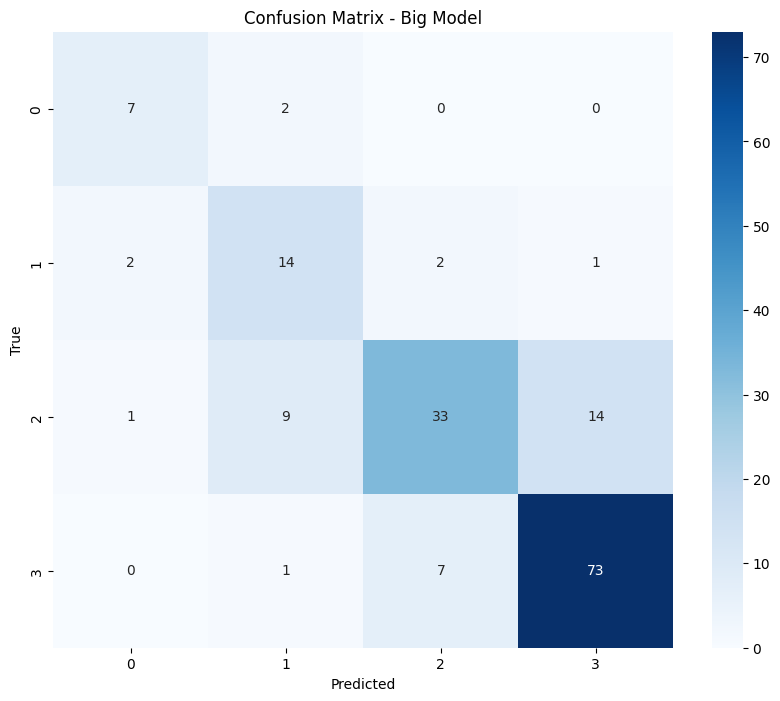

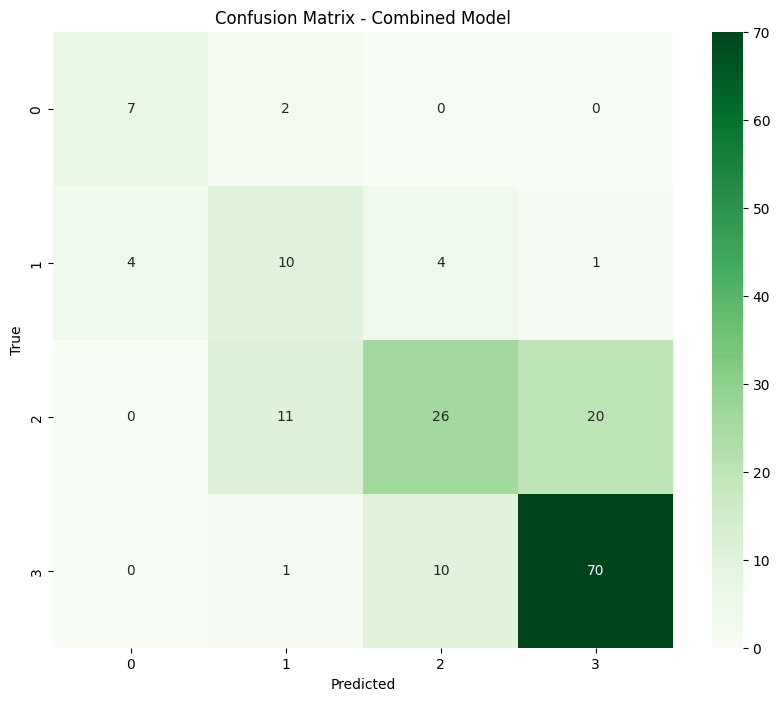

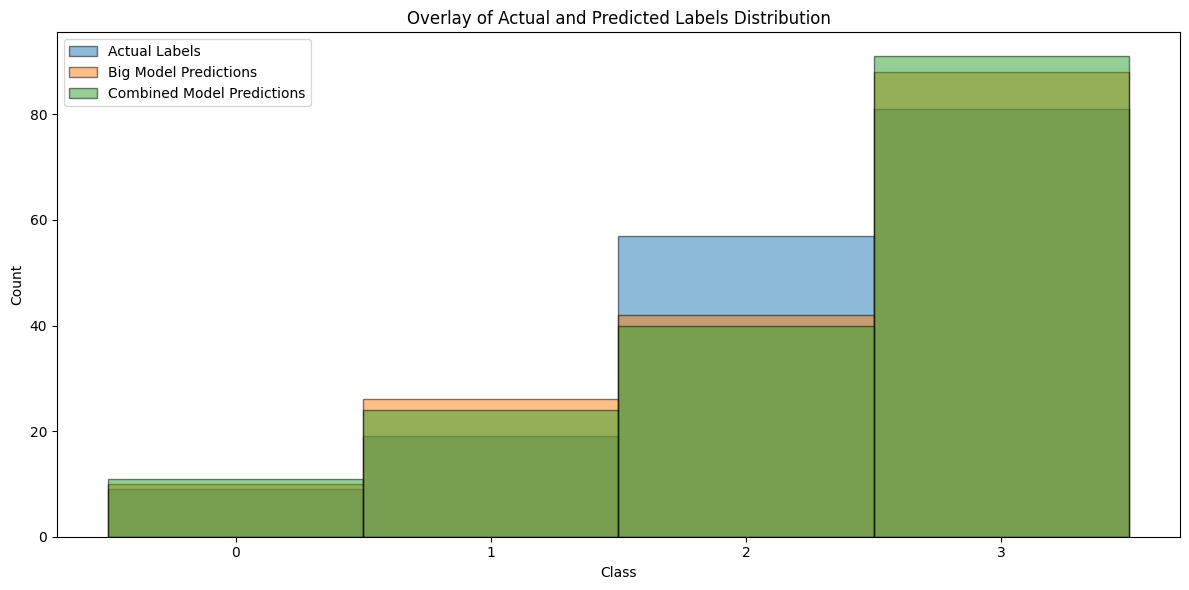

: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

best_model_path = os.path.join(cnn_log_directory, 'model0704.keras')
#best_model_path= f"{load_directory}/{load_model_name}"
model = tf.keras.models.load_model(best_model_path)

model_1_2 = tf.keras.models.load_model(os.path.join(cnn_log_directory, 'best_model_1_2.keras'))
model_2_3 = tf.keras.models.load_model(os.path.join(cnn_log_directory, 'best_model_2_3.keras'))
model_3_4 = tf.keras.models.load_model(os.path.join(cnn_log_directory, 'best_model_3_4.keras'))

# Get predictions for the test set
# Get predictions from the big model
y_pred_big = model.predict(X_test)
y_pred_big_classes = np.argmax(y_pred_big, axis=1)

# Initialize an empty list for final predictions
y_pred_final_classes = []

# Iterate through each prediction from the big model
for i, pred_class in enumerate(y_pred_big_classes):
    if pred_class == 0:  # Class 1
        small_pred = model_1_2.predict(np.expand_dims(X_test[i], axis=0))
        y_pred_final_classes.append(np.argmax(small_pred)) 
    elif pred_class == 1:  # Class 2
        small_pred_1 = model_1_2.predict(np.expand_dims(X_test[i], axis=0))
        small_pred_2 = model_2_3.predict(np.expand_dims(X_test[i], axis=0))
        small_pred_1 = small_pred_1.flatten()
        small_pred_2 = small_pred_2.flatten()
        small_pred = [small_pred_1[0], 1/2 * (small_pred_1[1] + small_pred_2[0]), small_pred_2[1]]
        y_pred_final_classes.append(np.argmax(small_pred))  
    elif pred_class == 2:  # Class 3
        small_pred_1 = model_2_3.predict(np.expand_dims(X_test[i], axis=0))
        small_pred_2 = model_3_4.predict(np.expand_dims(X_test[i], axis=0))
        small_pred_1 = small_pred_1.flatten()
        small_pred_2 = small_pred_2.flatten()
        small_pred = [small_pred_1[0], 1/2 * (small_pred_1[1] + small_pred_2[0]), small_pred_2[1]]
        y_pred_final_classes.append(np.argmax(small_pred) + 1)  
    elif pred_class == 3:  # Class 3
        small_pred = model_3_4.predict(np.expand_dims(X_test[i], axis=0))
        y_pred_final_classes.append(np.argmax(small_pred) + 2) 

# Calculate test accuracy for the big model
y_test_classes = np.argmax(y_test, axis=1)
big_model_accuracy = accuracy_score(y_test_classes, y_pred_big_classes)
print(f'Big Model Test Accuracy: {big_model_accuracy:.4f}')

# Calculate test F1 score for the big model
big_model_f1_score = f1_score(y_test_classes, y_pred_big_classes, average='weighted')
print(f'Big Model Test F1 Score: {big_model_f1_score:.4f}')

# Calculate test accuracy for the combined model (big + smaller models)
combined_model_accuracy = accuracy_score(y_test_classes, y_pred_final_classes)
print(f'Combined Model Test Accuracy: {combined_model_accuracy:.4f}')

# Calculate test F1 score for the combined model
combined_model_f1_score = f1_score(y_test_classes, y_pred_final_classes, average='weighted')
print(f'Combined Model Test F1 Score: {combined_model_f1_score:.4f}')

# Plot confusion matrix for the big model
cm_big = confusion_matrix(y_test_classes, y_pred_big_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_big, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test_classes)), yticklabels=sorted(set(y_test_classes)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Big Model')
plt.show()

# Plot confusion matrix for the combined model
cm_combined = confusion_matrix(y_test_classes, y_pred_final_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Greens', xticklabels=sorted(set(y_test_classes)), yticklabels=sorted(set(y_test_classes)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Combined Model')
plt.show()

# Overlay histograms of actual and predicted labels for both models
plt.figure(figsize=(12, 6))
plt.hist(y_test_classes, bins=np.arange(num_classes + 1) - 0.5, alpha=0.5, label='Actual Labels', edgecolor='black')
plt.hist(y_pred_big_classes, bins=np.arange(num_classes + 1) - 0.5, alpha=0.5, label='Big Model Predictions', edgecolor='black')
plt.hist(y_pred_final_classes, bins=np.arange(num_classes + 1) - 0.5, alpha=0.5, label='Combined Model Predictions', edgecolor='black')
plt.xticks(range(num_classes))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Overlay of Actual and Predicted Labels Distribution')
plt.legend()
plt.tight_layout()
plt.show()
